In [1]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft2, irfft2
from matplotlib.animation import FuncAnimation

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

y, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None

with h5py.File(h5_files[1], "r") as data:
    y = data["y"][100:]
    Hs = data.attrs["Hs"]
    Tp = data.attrs["Tp"]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

In [ ]:
# Creating dataset
from scipy.interpolate import griddata

index = 0

eta_hat = y[index:index+121, 0]
phi_hat = y[index:index+121, 1]

mes_index_1 = np.argmin(np.abs(x - 1300))
mes_index_2 = np.argmin(np.abs(x - 1700))

eta = irfft2(eta_hat).astype(np.float32)
phi = irfft2(phi_hat).astype(np.float32)

eta[:, mes_index_1:mes_index_2, mes_index_1:mes_index_2] = 0
phi[:, mes_index_1:mes_index_2, mes_index_1:mes_index_2] = 0

##
for i in range(mes_index_1, mes_index_2):
    eta[0, mes_index_1:mes_index_2, i] = (eta[0, mes_index_1-1, i] + eta[0, mes_index_2+1, i]) * 0.5 # juks?
##

eta_hat = rfft2(eta).astype(np.complex64)
phi_hat = rfft2(phi).astype(np.complex64)

modes = eta_hat.shape[-1]-1
mHOS = 4
index = modes * 2 // (mHOS + 1)
alias_mask = np.ones((2*modes, modes+1))
alias_mask[index+1:-index, :] = 0
alias_mask[:, index+1:] = 0

eta_hat = eta_hat * alias_mask
phi_hat = phi_hat * alias_mask

eta = irfft2(eta_hat).astype(np.float32)
phi = irfft2(phi_hat).astype(np.float32)


# Results

The Fourier Neural Operator (FNO) significantly outperforms the Artificial Neural Network (ANN) in terms of prediction accuracy. This is largely due to the FNO's ability to capture patterns in the Fourier domain, making it particularly effective for modeling wave dynamics governed by partial differential equations (PDEs).

# Physical Approach

The physical approach is based on the Higher-Order Spectral (HOS) method with order 8, combined with a Luenberger observer. Wave fields are time-integrated both forward and backward over the measurement window before being propagated to the target location in time.

The resulting predictions are shown below. You can view an animation of how the physical approach works here: [Physical Wave Prediction](https://vegabaar.folk.ntnu.no/wave_prediction_HOSM.html)


C:\Users\Vegard\AppData\Local\Temp\ipykernel_19748\1510352497.py:29: RuntimeWarning: divide by zero encountered in divide
  L2 = 1.0 / K - 9.81


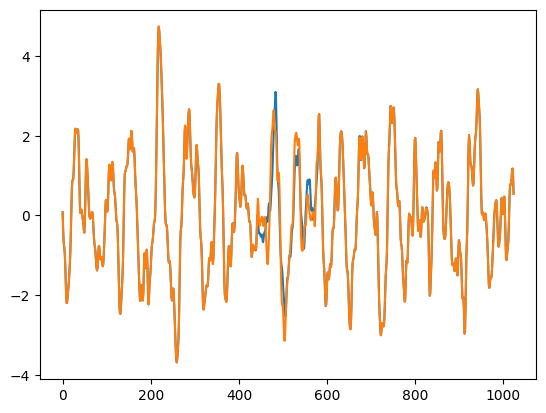

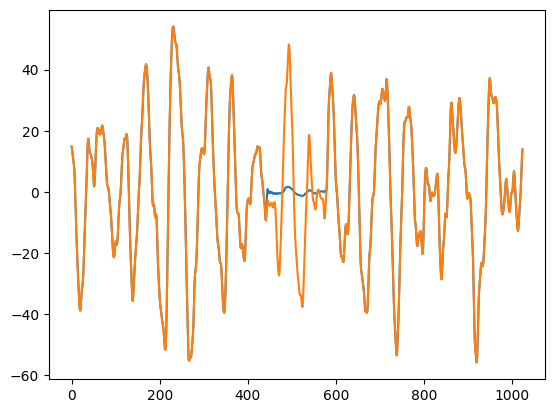

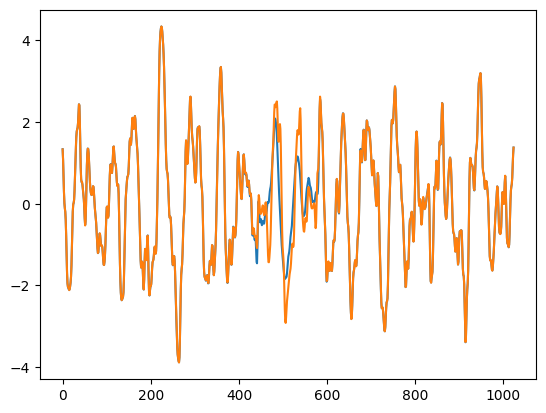

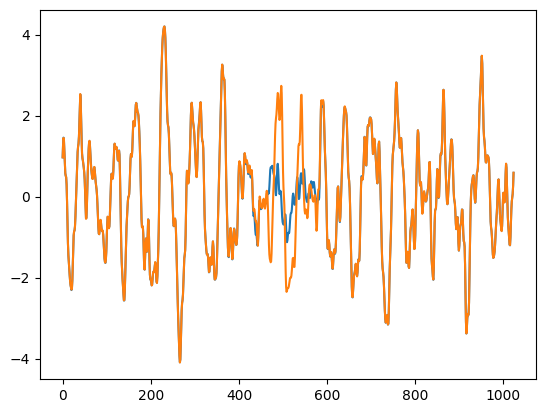

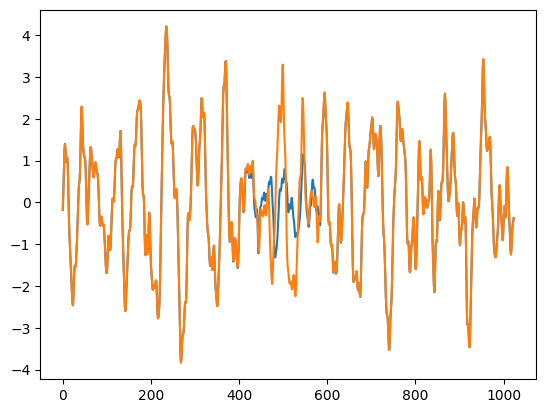

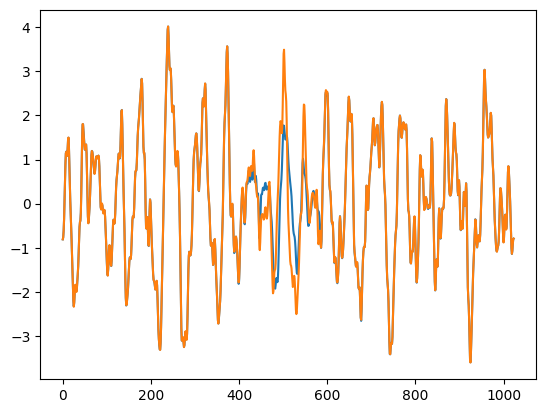

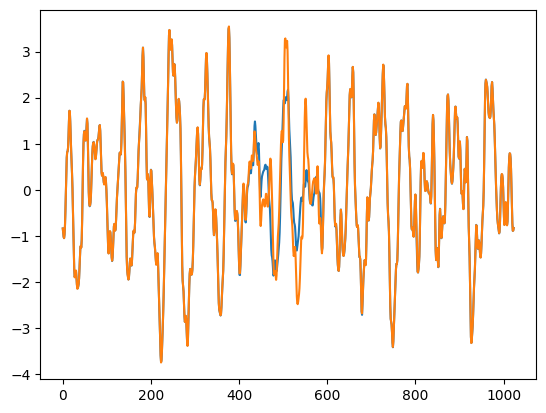

KeyboardInterrupt: 

In [37]:
import jax
import jax.numpy as jnp

sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from HOSim import solver

f_jit = jax.jit(solver.f2d, static_argnums=(2, 3, 4, 5, 6))
rk4_step_jit = solver.rk4_step

# L2 = 1.0 / (np.arange(1, X.shape[-1]//2+1) * 2 * np.pi / length) - g
# L2 = np.insert(L2, 0, 0)

# for index in range(X_train.shape[0]):

eta_hat_0 = jnp.asarray(eta_hat[0])
phi_hat_0 = jnp.asarray(phi_hat[0])

y_hat = jnp.stack([eta_hat_0, phi_hat_0])
modes = y_hat.shape[-1]-1
k0 = 2 * np.pi / length

L1 = np.ones(eta_hat_0.shape[-2:])*2
L1[0, 0] = 0
ky = np.arange(0, modes+1)*k0
kx = np.concatenate((ky, -ky[1:-1][::-1]))
KX, KY = jnp.meshgrid(kx, ky, indexing="ij")
K = np.sqrt(KX**2 + KY**2)
L2 = 1.0 / K - 9.81
L2[0, 0] = 0

# eta_saved = np.zeros((6 * 20 + 1, eta_0.shape[0]))
# eta_obs = X_train[index, 0, :]

y_hat = y_hat.at[0, 31:-31, :].set(0)
y_hat = y_hat.at[1, 31:-31, :].set(0)

plt.plot(irfft2(y_hat[0])[modes, :])
plt.plot(irfft2(y[0, 0])[modes, :])
plt.show()

plt.plot(irfft2(y_hat[1])[modes, :])
plt.plot(irfft2(y[0, 1])[modes, :])
plt.show()

sim_mins = 6+6
y_saved = np.zeros((sim_mins*10+1, *y_hat.shape), dtype=np.complex64)
y_saved[0] = y_hat

for i in range(sim_mins):
    for j in range(1, 401):
        y_hat = rk4_step_jit(200, y_hat, 0.025, modes, 9.81, k0, 4, 0.001, f_jit)
        y_hat = y_hat.at[0, 31:-31, :].set(0)
        y_hat = y_hat.at[1, 31:-31, :].set(0)

        if j % 40 == 0:
            y_saved[i*10+j//40] = y_hat
            plt.plot(irfft2(y_hat[0])[modes, :])
            plt.plot(irfft2(y[j//40, 0])[modes, :])
            plt.show()

    if i < 6:
        print("old")
        y_old = irfft2(y_hat)
        plt.plot(irfft2(y_hat[0])[modes, :], label="sim")
        plt.plot(irfft2(y[(i+1)*10, 0])[modes, :], label="Actual")
        plt.legend()
        plt.show()

        y_obs = irfft2(y[(i+1)*10, 0])
        y_obs[mes_index_1:mes_index_2, mes_index_1:mes_index_2] = irfft2(y_hat[0])[mes_index_1:mes_index_2, mes_index_1:mes_index_2]
        y_obs_hat = rfft2(y_obs)
        y_hat = y_hat.at[0].add(0.5 * L1 * (y_obs_hat - y_hat[0]))
        y_hat = y_hat.at[1].add(0.5 * L2 * (y_obs_hat - y_hat[0]))

        print("corrected")
        plt.plot(irfft2(y_hat[0])[modes, :], label="sim")
        plt.plot(irfft2(y[(i+1)*10, 0])[modes, :], label="Actual")
        plt.legend()
        plt.show()

    print(f"{i}-done")

In [11]:
np.savez_compressed('physical_2d_2.npz', y_saved=y_saved)

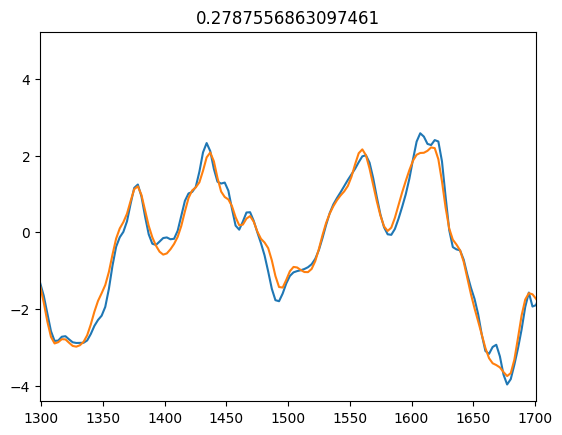

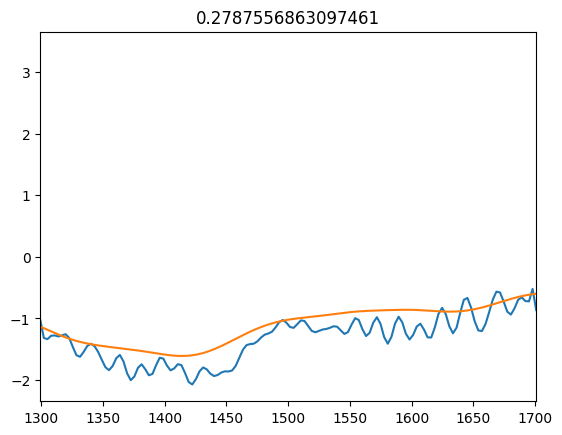

In [12]:
plt.plot(x, irfft2(y_hat[0])[modes, :])
plt.plot(x, irfft2(y[120, 0])[modes, :])
plt.xlim(x[mes_index_1], x[mes_index_2])
error = irfft2(y_hat[0])[mes_index_1:mes_index_2, mes_index_1:mes_index_2] - irfft2(y[120, 0])[mes_index_1:mes_index_2, mes_index_1:mes_index_2]
RMSE = np.sqrt(np.mean(error**2))
plt.title(RMSE)
plt.show()

plt.plot(x, irfft2(y_hat[0])[:, modes])
plt.plot(x, irfft2(y[120, 0])[:, modes])
plt.xlim(x[mes_index_1], x[mes_index_2])
error = irfft2(y_hat[0])[mes_index_1:mes_index_2, mes_index_1:mes_index_2] - irfft2(y[120, 0])[mes_index_1:mes_index_2, mes_index_1:mes_index_2]
RMSE = np.sqrt(np.mean(error**2))
plt.title(RMSE)
plt.show()

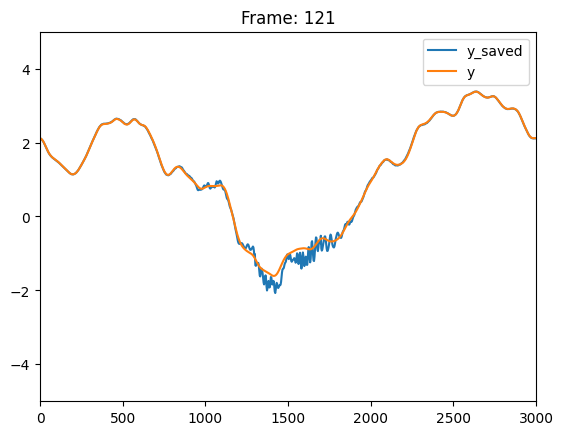

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from numpy.fft import irfft2

fig, ax = plt.subplots()

line1, = ax.plot([], [], label='y_saved')
line2, = ax.plot([], [], label='y')
ax.legend()

ax.set_xlim(0, x[-1])
ax.set_ylim(-5, 5)

def update(frame):
    ys = irfft2(y_saved[frame, 0])[:, modes]
    y_orig = irfft2(y[frame, 0])[:, modes]
    line1.set_data(x, ys)
    line2.set_data(x, y_orig)
    ax.set_title(f"Frame: {frame+1}")
    return line1, line2

# Keep a strong reference to the animation object
ani = FuncAnimation(fig, update, frames=121, blit=True)
ani.save('short_animation.gif', writer=PillowWriter(fps=10))
plt.show()


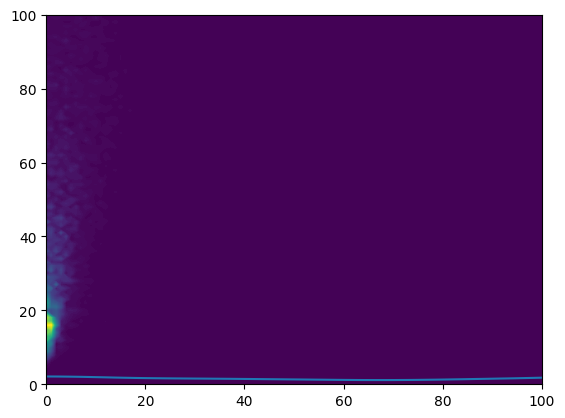

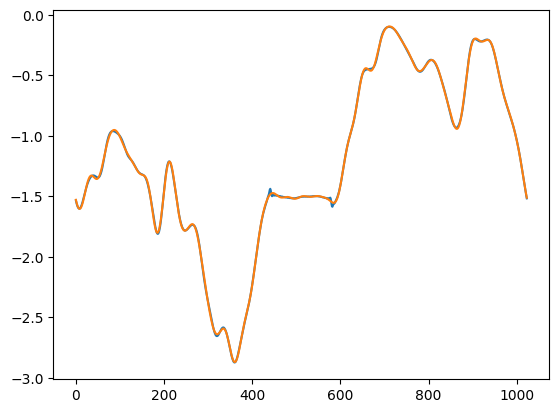

In [35]:
plt.plot(irfft2(y_saved[-1, 0])[:, modes])

test = np.concatenate((y_saved[-1, 0], y_saved[-1, 0][:, 1:-1][::, ::-1]), axis=-1)
plt.contourf(np.abs(test).transpose(), levels=100)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

test = y_saved[0, 0].copy()
test[30:-30, :] = 0

plt.plot(irfft2(y_saved[0, 0])[:, modes])
plt.plot(irfft2(test)[:, modes])
plt.show()


(2, 1024, 1024) (1024, 1024) (2, 1024, 513)


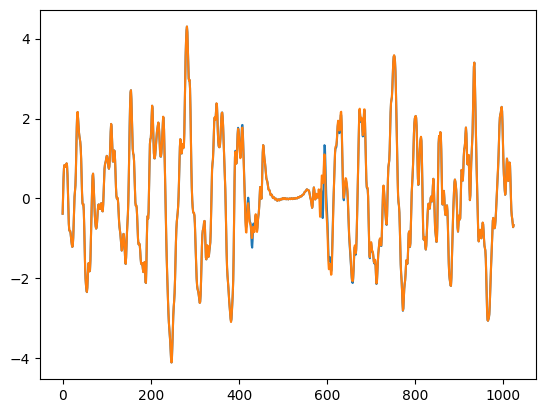

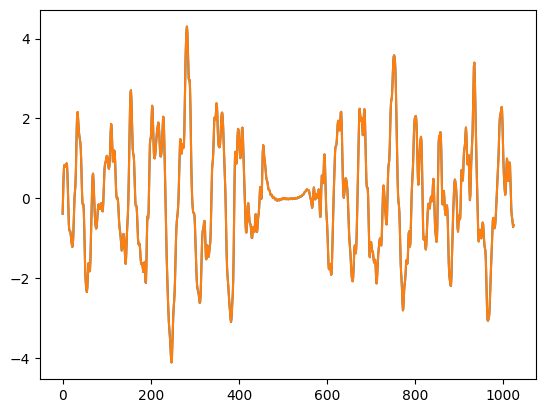

In [ ]:
0print(y_old.shape, y_obs.shape, y_hat.shape)

# y_obs = irfft2(y[(i+1)*10, 0])
# y_obs[mes_index_1:mes_index_2, mes_index_1:mes_index_2] = irfft2(y_hat[0])[mes_index_1:mes_index_2, mes_index_1:mes_index_2]
# y_obs_hat = rfft2(y_obs)
# y_hat.at[0].add(0.5 * L1 * (y_obs_hat - y_hat[0]))
# y_hat.at[1].add(0.5 * L2 * (y_obs_hat - y_hat[0]))

y_hat_ = y_hat.copy()

y_hat_ = y_hat_.at[0].add(0.5 * L1 * (rfft2(y_obs) - y_hat_[0]))
y_hat_ = y_hat_.at[1].add(0.5 * L2 * (rfft2(y_obs) - y_hat_[0]))

plt.plot(y_old[0, modes, :])
plt.plot(y_obs[modes, :])
plt.show()

plt.plot(irfft2(y_hat_[0])[modes, :])
plt.plot(y_obs[modes, :])
plt.show()

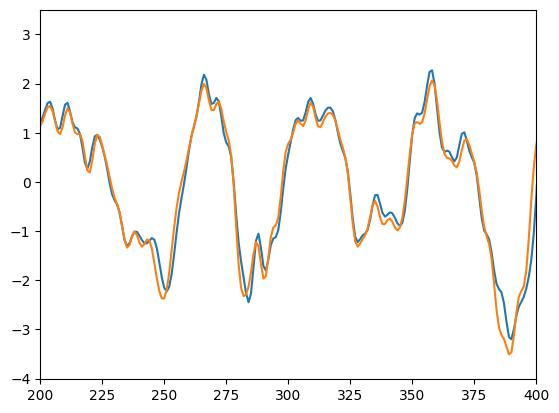

In [ ]:
i = 0
y_sim = irfft2(y_hat[0])
y_obs = irfft2(eta_hat[(i+1)*10])
y_obs[mes_index_1:mes_index_2, mes_index_1:mes_index_2] = y_sim[mes_index_1:mes_index_2, mes_index_1:mes_index_2]
plt.plot(y_sim[modes, :])
plt.plot(y_obs[modes, :])
plt.show()

In [179]:
import jax
import jax.numpy as jnp

sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from HOSim import solver

f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6))
rk4_step_jit = jax.jit(solver.rk4_step, static_argnums=(2, 3, 4, 5, 6, 7, 8))
k = np.arange(0, X_train.shape[-1]//2+1) * 2 * np.pi / length
g = 9.81

L1 = np.ones(X_train.shape[-1]//2)*2
L1 = np.insert(L1, 0, 0)

L2 = 1.0 / (np.arange(1, X_train.shape[-1]//2+1) * 2 * np.pi / length) - g
L2 = np.insert(L2, 0, 0)

X_train_local = X_train[index, :, :].copy()

eta_0 = X_train_local[0, :]
eta_hat_0 = rfft(eta_0)
phi_hat_0 = eta_hat_0[1:] * np.exp(-1.j * np.pi / 2) * np.sqrt(g / k[1:])
phi_hat_0 = np.insert(phi_hat_0, 0, 0)

y_hat = jnp.asarray(np.concatenate((eta_hat_0, phi_hat_0)), dtype=jnp.complex128)

eta_obs = X_train_local[0, :]

iterations = 1

saved_data = np.zeros((iterations*6*2*20, len(eta_obs)))
saved_time = np.zeros(iterations*6*2*20)

for it in range(iterations):
    for i in range(6):
        for j in range(400):
            if j % 20 == 0:
                saved_data[it*(240) + i*20+j//20, :] = irfft(y_hat[:y_hat.shape[0]//2])
                saved_time[it*(240) + i*20+j//20] = (i*20+j//20)*0.5

            y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

        eta = irfft(y_hat[:y_hat.shape[0]//2])
        
        eta_obs = X_train_local[i+1, :]
        eta_obs[cut_index:] = eta[cut_index:]
        eta_hat_obs = rfft(eta_obs)

        X_train_local[i+1, :] = eta_obs # new

        y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
        y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

    y_hat = y_hat.at[y_hat.shape[0]//2:].multiply(jnp.exp(-1.j*jnp.pi))
    X_train_local[:, :] = X_train_local[::-1, :]

    for i in range(6):
        for j in range(400):
            if j % 20 == 0:
                saved_data[it*(240)+120+i*20+j//20, :] = irfft(y_hat[:y_hat.shape[0]//2])
                saved_time[it*(240)+120+i*20+j//20] = 60 - (i*20+j//20)*0.5

            y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

        if i < 6:
            eta = irfft(y_hat[:y_hat.shape[0]//2])
            
            eta_obs = X_train_local[i+1, :]
            eta_obs[cut_index:] = eta[cut_index:]
            eta_hat_obs = rfft(eta_obs)

            X_train_local[i+1, :] = eta_obs # new

            y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
            y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

    y_hat = y_hat.at[y_hat.shape[0]//2:].multiply(jnp.exp(1.j * np.pi))
    X_train_local[:, :] = X_train_local[::-1, :]

saved_data_2 = np.zeros(((6+14)*20+1, len(eta_obs)))
saved_time_2 = np.zeros((6+14)*20)

for i in range(6+14):
    for j in range(400):
        if j % 20 == 0:
            saved_data_2[i*20+j//20, :] = irfft(y_hat[:y_hat.shape[0]//2])
            saved_time_2[i*20+j//20] = (i*20+j//20)*0.5

        y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

    if i < 6:
        eta = irfft(y_hat[:y_hat.shape[0]//2])
        
        eta_obs = X_train_local[i+1, :]
        eta_obs[cut_index:] = eta[cut_index:]
        eta_hat_obs = rfft(eta_obs)

        X_train_local[i+1, :] = eta_obs # new

        y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
        y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

saved_data_2[-1, :] = irfft(y_hat[:y_hat.shape[0]//2])

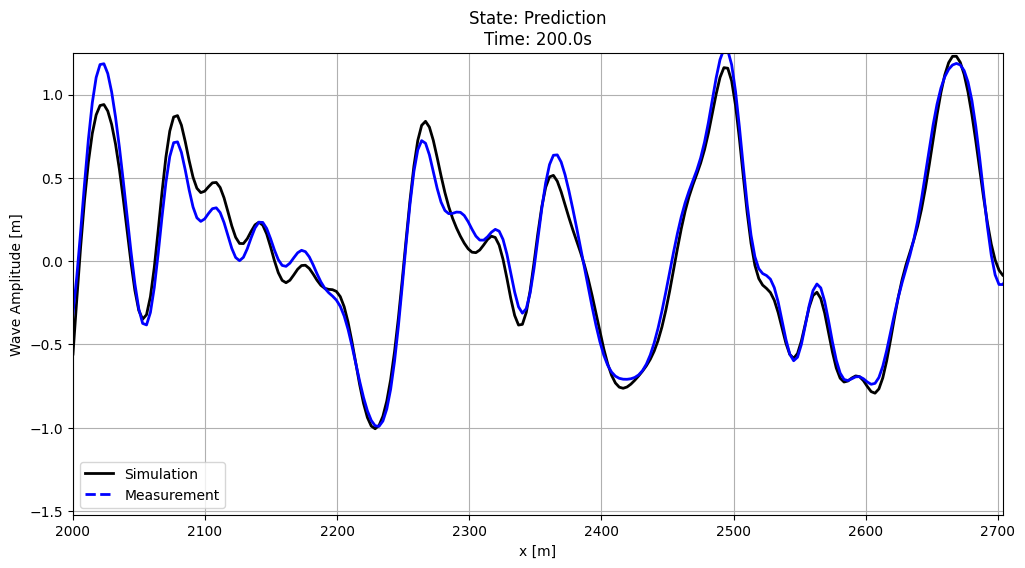

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np 

fig, ax = plt.subplots(figsize=(12, 6))
line, = ax.plot([], [], lw=2, color="k")
line_pred, = ax.plot([], [], lw=2, color="y", label="Ground Truth")

ax.set_xlim(x[0], x[-1])
ax.set_ylim(np.min(saved_data), np.max(saved_data))
ax.set_xlabel("x [m]")
ax.set_ylabel("Wave Amplitude [m]")
ax.set_title(f"Prediction Time: {0.0:.1f}s")
ax.grid(True)

line_, = ax.plot([], [], lw=2, color="k", label="Simulation")
line__, = ax.plot([], [], lw=2, color="b", linestyle="--", label="Measurement")
ax.legend(loc=3)

def update(frame):
    if frame < saved_data.shape[0]:
        if frame % 20 == 0 or frame % 20 == 19:
            line.set_color("b")
            line.set_linestyle("--")
        else:
            line.set_color("k")
            line.set_linestyle("-")

        ax.set_title("State: Bouncing\n" + f"Time: {saved_time[frame]:.1f}s")
        y = saved_data[frame, :]
        line.set_data(x, y)
        return line,
    elif frame < saved_data.shape[0] + saved_data_2.shape[0] - 1:
        line.set_color("k")
        line.set_linestyle("-")
        f = frame - saved_data.shape[0]
        ax.set_title("State: Prediction\n" + f"Time: {saved_time_2[f]:.1f}s")
        y = saved_data_2[f, :]
        line.set_data(x, y)
        return line,
    else:
        ax.set_title("State: Prediction\n" + f"Time: {200.0:.1f}s")
        y = saved_data_2[-1, :]
        line.set_data(x, y)
        ax.set_xlim(x[cut_index], x[cut_index_2])
        line_pred.set_data(x, y_train[index, :])
        return line,line_pred

ani = animation.FuncAnimation(fig, update, frames=saved_data.shape[0]+saved_data_2.shape[0]+40, blit=True)
ani.save("wave_animation.gif", writer='pillow', fps=15)

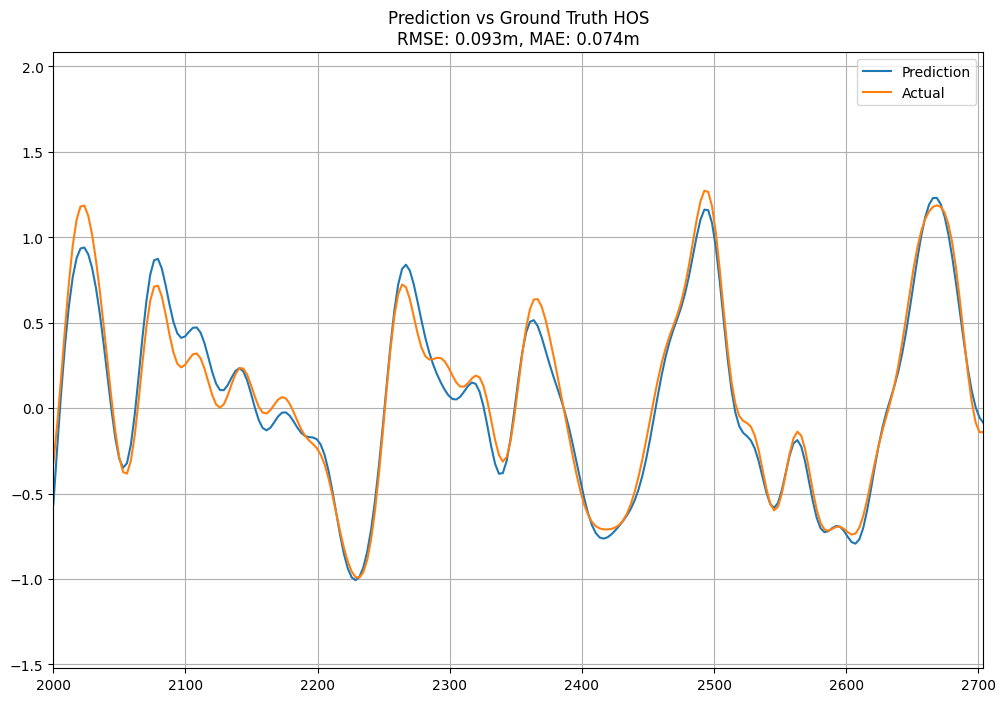

MAE: 7.44813e-02
RMSE: 9.28692e-02


In [ ]:
eta_pred = irfft(y_hat[:y_hat.shape[0]//2])
error = eta_pred[cut_index:cut_index_2] - y_train[index, cut_index:cut_index_2]

plt.figure(figsize=(12, 8))
plt.plot(x, eta_pred, label="Prediction")
plt.plot(x, y_train[index, :], label="Actual")
plt.xlim(x[cut_index], x[cut_index_2])
plt.title("Prediction vs Ground Truth HOS\n" + f"RMSE: {np.sqrt(np.mean(error**2)):.3f}m, MAE: {np.mean(np.abs(error)):.3f}m")
plt.legend()
plt.grid()
plt.show()

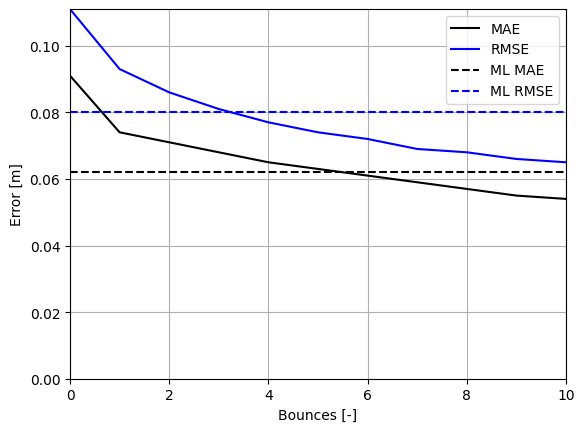

In [ ]:
mae = [0.091, 0.074, 0.071, 0.068, 0.065, 0.063, 0.061, 0.059, 0.057, 0.055, 0.054]
rmse = [0.111, 0.093, 0.086, 0.081, 0.077, 0.074, 0.072, 0.069, 0.068, 0.066, 0.065]

plt.plot(mae, label="MAE", color="k")
plt.plot(rmse, label="RMSE", color="b")
plt.ylim(0, rmse[0])
plt.xlim(0, len(mae)-1)
plt.grid()
plt.xlabel("Bounces [-]")
plt.ylabel("Error [m]")
plt.axhline(y=0.062, label="ML MAE", color="k", linestyle="--")
plt.axhline(y=0.080, label="ML RMSE", color="b", linestyle="--")
plt.legend()
plt.show()

jupyter nbconvert ML_update.ipynb --to pdf --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_input_tags="['hide_input']" --TagRemovePreprocessor.remove_all_outputs_tags="['hide_output']" --PDFExporter.preprocessors="['nbconvert.preprocessors.TagRemovePreprocessor']"
